# IF3170 Artificial Intelligence | Praktikum

This notebook serves as a template for the assignment. Please create a copy of this notebook to complete your work. You can add more code blocks, markdown blocks, or new sections if needed.


Group Number: xx

Group Members:
- Name (NIM)
- Name (NIM)

## Import Libraries

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.base import BaseEstimator, TransformerMixin
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.metrics import roc_curve, auc
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.calibration import LabelEncoder
from sklearn.preprocessing import PowerTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings("ignore")

## Import Dataset

In [3]:
# Write your code here
df_train = pd.read_csv('data/train.csv')
df_test = pd.read_csv('data/test.csv')

# 1. Exploratory Data Analysis

Exploratory Data Analysis (EDA) is a crucial step in the data analysis process that involves examining and visualizing data sets to uncover patterns, trends, anomalies, and insights. It is the first step before applying more advanced statistical and machine learning techniques. EDA helps you to gain a deep understanding of the data you are working with, allowing you to make informed decisions and formulate hypotheses for further analysis.

In [4]:
df_train.drop('id', axis=1, inplace=True)

In [5]:
# Write your code here
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   N_Days         15000 non-null  float64
 1   Drug           8450 non-null   object 
 2   Age            15000 non-null  float64
 3   Sex            15000 non-null  object 
 4   Ascites        8453 non-null   object 
 5   Hepatomegaly   8448 non-null   object 
 6   Spiders        8441 non-null   object 
 7   Edema          15000 non-null  object 
 8   Bilirubin      15000 non-null  float64
 9   Cholesterol    6626 non-null   float64
 10  Albumin        15000 non-null  float64
 11  Copper         8340 non-null   float64
 12  Alk_Phos       8444 non-null   float64
 13  SGOT           8441 non-null   float64
 14  Tryglicerides  6575 non-null   float64
 15  Platelets      14416 non-null  float64
 16  Prothrombin    14984 non-null  float64
 17  Stage          15000 non-null  float64
 18  Status

# 2. Split Training Set and Validation Set

Splitting the training and validation set works as an early diagnostic towards the performance of the model we train. This is done before the preprocessing steps to **avoid data leakage inbetween the sets**. If you want to use k-fold cross-validation, split the data later and do the cleaning and preprocessing separately for each split.

Note: For training, you should use the data contained in the `train.csv` given by the TA. The `test.csv` data is only used for kaggle submission.

In [6]:
target_columns = ['Status']
# cat_columns = list(df_train.select_dtypes(include='object').columns) + list(['Stage'])
cat_columns = list(df_train.select_dtypes(include='object').columns)
indices_to_remove = [i for i, val in enumerate(cat_columns) if val in target_columns]
cat_columns = np.delete(cat_columns, indices_to_remove)
num_columns = [x for x in df_train.columns if x not in cat_columns and x not in target_columns]

In [7]:
X_train = df_train.drop(target_columns, axis=1)
y_train = df_train[target_columns]

In [8]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# 3. Data Cleaning and Preprocessing

This step is the first thing to be done once a Data Scientist have grasped a general knowledge of the data. Raw data is **seldom ready for training**, therefore steps need to be taken to clean and format the data for the Machine Learning model to interpret.

By performing data cleaning and preprocessing, you ensure that your dataset is ready for model training, leading to more accurate and reliable machine learning results. These steps are essential for transforming raw data into a format that machine learning algorithms can effectively learn from and make predictions.

For each step that you will do, **please explain the reason why did you do that process. Write it in a markdown cell under the code cell you wrote.**

In [9]:
len(X_train[X_train.isna().any(axis=1)]) * 100 /len(X_train)

58.35

In [10]:
missing_column = []
for column in num_columns:
    missing_percentage = X_train[column].isna().sum() / len(X_train) * 100
    if missing_percentage > 5:
        missing_column.append(column)
    print(f"Column {column} - {missing_percentage:.2f}% missing values")

Column N_Days - 0.00% missing values
Column Age - 0.00% missing values
Column Bilirubin - 0.00% missing values
Column Cholesterol - 56.03% missing values
Column Albumin - 0.00% missing values
Column Copper - 44.47% missing values
Column Alk_Phos - 43.82% missing values
Column SGOT - 43.84% missing values
Column Tryglicerides - 56.42% missing values
Column Platelets - 3.92% missing values
Column Prothrombin - 0.09% missing values
Column Stage - 0.00% missing values


In [11]:
for column in cat_columns:
    missing_percentage = X_train[column].isna().sum() / len(X_train) * 100
    if missing_percentage > 5:
        missing_column.append(column)
    print(f"Column {column} - {missing_percentage:.2f}% missing values")

Column Drug - 43.81% missing values
Column Sex - 0.00% missing values
Column Ascites - 43.77% missing values
Column Hepatomegaly - 43.82% missing values
Column Spiders - 43.84% missing values
Column Edema - 0.00% missing values


In [12]:
print('Platelets', ":", df_train['Platelets'].skew())

Platelets : 2.340967199225039


In [13]:
class MissingValueHandler(BaseEstimator, TransformerMixin):
    def __init__(self, isNum = False, isNewCat = False):
        self.isNum = isNum
        self.isNewCat = isNewCat
        return

    def fit(self, X, y=None):
        return self 
    
    def transform(self, X, y=None):
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)
        if (self.isNum):
            simple_imputer = SimpleImputer(strategy='mean')
        else:
            simple_imputer = SimpleImputer(strategy='most_frequent')

        for col in X.columns:
            X[[col]] = simple_imputer.fit_transform(X[[col]])
            if (self.isNewCat):
                X[col] = X[col].fillna("Missing")

        return X

missing_value_handler = MissingValueHandler()
mo_X_train = missing_value_handler.fit_transform(X_train)
# mo_X_train_df = pd.DataFrame(mo_X_train, columns=[x for x in (list(cat_columns) + list(num_columns)) if x not in missing_column])

In [14]:
class NumClipper(BaseEstimator, TransformerMixin):
    def __init__(self, isToCat=False):
        self.isToCat = isToCat
        self.clip_values_ = None

    def fit(self, X, y=None):
        X_df = pd.DataFrame(X)
        self.clip_values_ = X_df.quantile(0.85)
        return self
    
    def transform(self, X, y=None):
        X_df = pd.DataFrame(X)
        X_clipped = X_df.clip(upper=self.clip_values_, axis=1)

        if self.isToCat:
            X_clipped = X_clipped.applymap(lambda x: 1 if x == self.clip_values_ else 0)
        
        return X_clipped

In [15]:
class TargetEncoder(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.target_means_ = {}

    def fit(self, X, y=None):
        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)

        for col in X.columns:
            self.target_means_[col] = y.groupby(X[col]).mean().to_dict()
        
        return self
    
    def transform(self, X, y=None):
        print('target encode')

        if not isinstance(X, pd.DataFrame):
            X = pd.DataFrame(X)

        X_encoded = X.copy()
        for col, mapping in self.target_means_.items():
            if col in X_encoded.columns:
                X_encoded[col] = X_encoded[col].map(mapping).fillna(0)

        return X_encoded

# 3. Compile Preprocessing Pipeline

All of the preprocessing classes or functions defined earlier will be compiled in this step.

If you use sklearn to create preprocessing classes, you can list your preprocessing classes in the Pipeline object sequentially, and then fit and transform your data.

In [16]:
# Note: You can add or delete preprocessing components from this pipeline
cat_pipeline = Pipeline([
    ('imputer', MissingValueHandler(isNum=False, isNewCat=False)),
    ('encoder', TargetEncoder()),
    # ('encoder', OneHotEncoder(handle_unknown='ignore')),
])

num_pipeline = Pipeline([
    ('imputer', MissingValueHandler(isNum=True)),
    ('numClipper', NumClipper()),
    ('transformer', PowerTransformer(method='yeo-johnson')),
    ('Scaler', StandardScaler())
])

num_cat_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_columns),
    ("cat", cat_pipeline, cat_columns)
])

final_pipeline = Pipeline([
    ('num_cat', num_cat_pipeline)
])

label_encoder = LabelEncoder()
y_train = pd.DataFrame(label_encoder.fit_transform(y_train))
y_val = pd.DataFrame(label_encoder.fit_transform(y_val))

X_train_prepared = final_pipeline.fit_transform(X_train, y_train)
X_test_prepared = final_pipeline.fit_transform(X_val, y_val)

target encode
target encode


or create your own here

In [17]:
# Write your code here

# 4. Modeling and Validation

Modelling is the process of building your own machine learning models to solve specific problems, or in this assignment context, predicting the probability for each class in the `Status` feature (`Status_C`, `Status_CL`, `Status_D`). Validation is the process of evaluating your trained model using the validation set or cross-validation method and providing some metrics that can help you decide what to do in the next iteration of development.

In [18]:
def plot_roc(y_test, y_pred_proba):
    n_classes = y_test.shape[1]  # Number of classes
    class_labels = ['C', 'CL', 'D']  # Custom class labels
    
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    # Calculate ROC curve for each class
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_proba[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Plot ROC curves for each class
    plt.figure(figsize=(8, 6))
    for i in range(n_classes):
        plt.plot(fpr[i], tpr[i], lw=2, label=f'Class {class_labels[i]} (area = {roc_auc[i]:.2f})')
    
    # Plot random guess line
    plt.plot([0, 1], [0, 1], color='grey', lw=2, linestyle='--')
    
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Multi-class ROC')
    plt.legend(loc="lower right")
    plt.show()

In [19]:
def feature_importances_plot(model):
    importances = model.feature_importances_
    feature_names = X_train.columns

    plt.barh(feature_names, importances)
    plt.xlabel('Feature Importance')
    plt.title('Feature Importance Plot')
    plt.show()

In [20]:
# Initialize the LabelBinarizer
lb = LabelBinarizer()

# Fit and transform y_val to one-hot encoding
y_val = lb.fit_transform(y_val)

In [21]:
X_train_prepared.shape

(12000, 18)

In [22]:
X_test_prepared.shape

(3000, 18)

## KNN

In [23]:
# param_grid_knn = {
#     'n_neighbors': [100, 200, 400, 500],
#     'weights': ['uniform', 'distance'],
#     'metric': ['euclidean', 'manhattan']
# }

# grid_knn = GridSearchCV(KNeighborsClassifier(), param_grid_knn, scoring='neg_log_loss', cv=5)
# grid_knn.fit(X_train_prepared, y_train)
# print("Best KNN Parameters:", grid_knn.best_params_)

# Best KNN Parameters: {'metric': 'manhattan', 'n_neighbors': 200, 'weights': 'distance'}
knn_best_params = {'metric': 'manhattan', 'n_neighbors': 200, 'weights': 'distance'}

In [24]:
# Type your code here
knn = KNeighborsClassifier(**knn_best_params)
knn.fit(X_train_prepared, y_train)

# Predict
y_pred = knn.predict_proba(X_test_prepared)

In [25]:
loss = log_loss(y_val, y_pred)
print(f'Log Loss: {loss}')

Log Loss: 0.4348985123820833


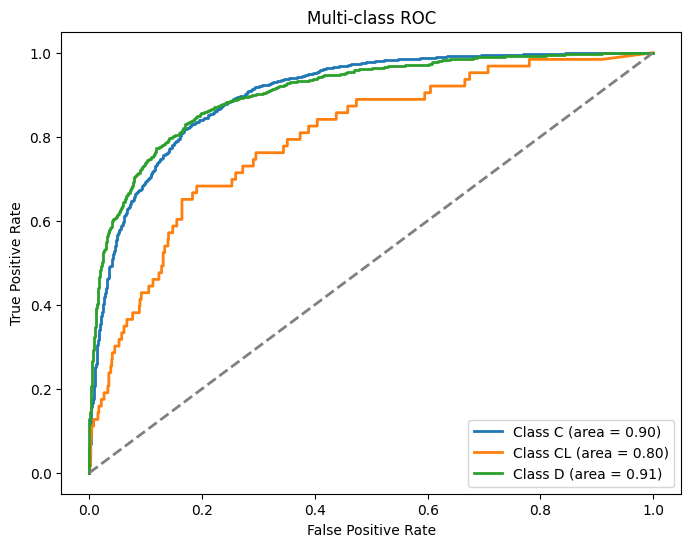

In [26]:
plot_roc(y_val, y_pred)

## Naive Bayes

In [27]:
# param_grid_nb = {
#     'var_smoothing': [1e-4, 1e-3, 1e-2, 1]
# }

# grid_nb = GridSearchCV(GaussianNB(), param_grid_nb, scoring='neg_log_loss', cv=5)
# grid_nb.fit(X_train_prepared, y_train)
# print("Best Naive Bayes Parameters:", grid_nb.best_params_)
# Best Naive Bayes Parameters: {'var_smoothing': 1}

n_bayes_best_params = {'var_smoothing': 1}

In [28]:
# Type your code here
gaussiannb = GaussianNB(**n_bayes_best_params)
# gaussiannb = GaussianNB()
gaussiannb.fit(X_train_prepared, y_train)

# Predict
y_pred = knn.predict_proba(X_test_prepared)

In [29]:
loss = log_loss(y_val, y_pred)
print(f'Log Loss: {loss}')

Log Loss: 0.4348985123820833


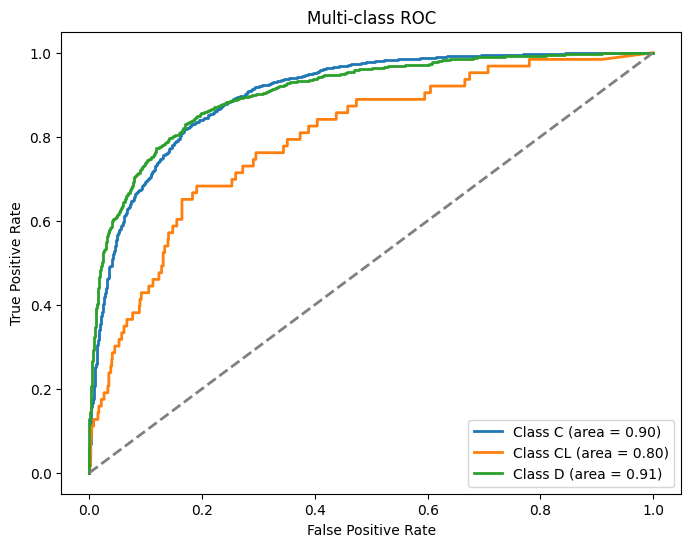

In [30]:
plot_roc(y_val, y_pred)

## ID3

In [31]:
# param_grid_id3 = {
#     'criterion': ['entropy'],
#     'max_depth': [1, 3, 5],
#     'min_samples_split': [1, 2, 5]
# }

# grid_id3 = GridSearchCV(DecisionTreeClassifier(), param_grid_id3, scoring='neg_log_loss', cv=5)
# grid_id3.fit(X_train_prepared, y_train)
# print("Best ID3 Parameters:", grid_id3.best_params_)
# Best ID3 Parameters: {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 2}

id3_best_params = {'criterion': 'entropy', 'max_depth': 3, 'min_samples_split': 2}

In [32]:
# Type your code here
id3 = DecisionTreeClassifier(**id3_best_params)
id3.fit(X_train_prepared, y_train)

# Predict
y_pred = id3.predict_proba(X_test_prepared)

loss = log_loss(y_val, y_pred)
print(f'Log Loss: {loss}')

Log Loss: 0.4514033010479179


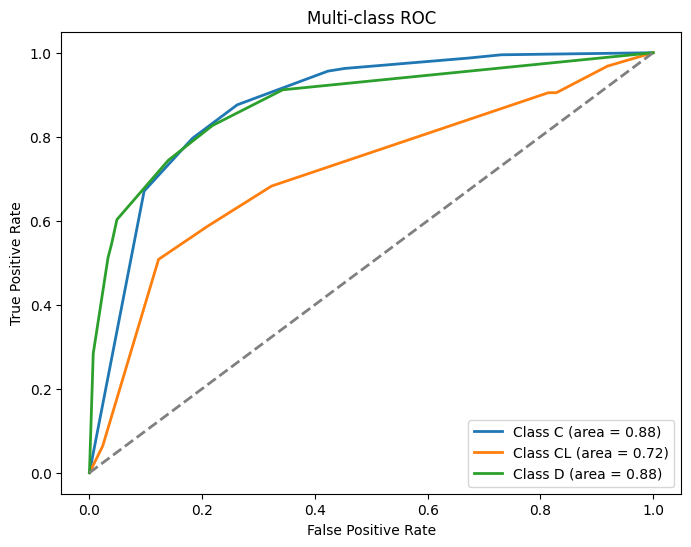

In [33]:
plot_roc(y_val, y_pred)

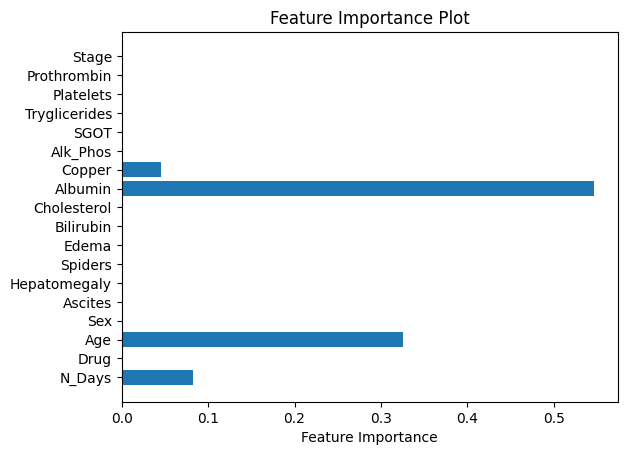

In [34]:
feature_importances_plot(id3)

## SVM

In [ ]:
param_grid_svm = {
    'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto']
}

grid_svm = GridSearchCV(SVC(probability=True), param_grid_svm, scoring='neg_log_loss', cv=5)
grid_svm.fit(X_train_prepared, y_train)
print("Best SVM Parameters:", grid_svm.best_params_)

In [ ]:
# Type your code here
svm = SVC(probability=True)
svm.fit(X_train_prepared, y_train)

# Predict
y_pred = svm.predict_proba(X_test_prepared)

loss = log_loss(y_val, y_pred)
print(f'Log Loss: {loss}')

In [ ]:
plot_roc(y_val, y_pred)

## Logistic Regression

In [ ]:
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2', 'elasticnet'],
    'solver': ['liblinear', 'saga']
}

grid_lr = GridSearchCV(LogisticRegression(max_iter=1000), param_grid_lr, scoring='neg_log_loss', cv=5)
grid_lr.fit(X_train_prepared, y_train)
print("Best Logistic Regression Parameters:", grid_lr.best_params_)

log_reg_best_param = grid_lr.best_params_

In [ ]:
# Type your code here
logisticregression = LogisticRegression(**log_reg_best_param)
logisticregression.fit(X_train_prepared, y_train)

# Predict
y_pred = logisticregression.predict_proba(X_test_prepared)

loss = log_loss(y_val, y_pred)
print(f'Log Loss: {loss}')

Log Loss: 0.42963587114439317


In [ ]:
plot_roc(y_val, y_pred)

## CatBoost

In [ ]:
param_grid_catboost = {
    'iterations': [1000, 3000],
    'depth': [4, 6, 8],
    'learning_rate': [0.1, 0.2, 0.3]
}

grid_catboost = GridSearchCV(CatBoostClassifier(verbose=0), param_grid_catboost, scoring='neg_log_loss', cv=5)
grid_catboost.fit(X_train_prepared, y_train)
print("Best CatBoost Parameters:", grid_catboost.best_params_)

cb_best_param = grid_catboost.best_params_

0:	learn: 0.8455754	total: 2.13ms	remaining: 2.13s
200:	learn: 0.3975844	total: 407ms	remaining: 1.62s
400:	learn: 0.3908961	total: 802ms	remaining: 1.2s
600:	learn: 0.3861869	total: 1.24s	remaining: 826ms
800:	learn: 0.3829080	total: 1.64s	remaining: 407ms
999:	learn: 0.3798006	total: 2.09s	remaining: 0us
Log Loss: 0.4040665970147999


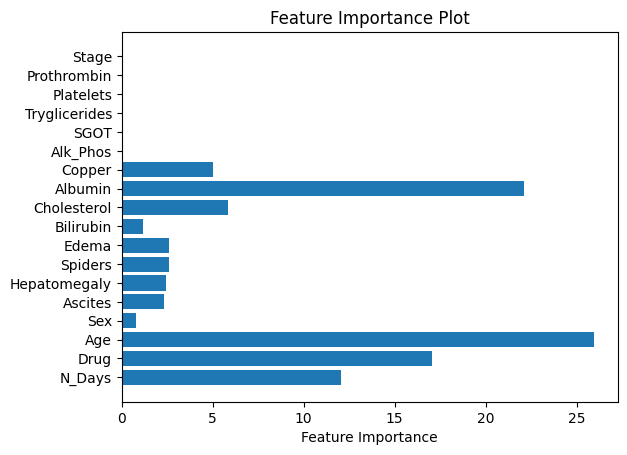

In [ ]:
catboost = CatBoostClassifier(**cb_best_param)

catboost.fit(X_train_prepared, y_train)

# Make predictions
y_pred = catboost.predict_proba(X_test_prepared)

loss = log_loss(y_val, y_pred)
print(f'Log Loss: {loss}')

In [ ]:
plot_roc(y_val, y_pred)

In [ ]:
feature_importances_plot(catboost)

## XGBoost

In [ ]:
param_grid_xgb = {
    'n_estimators': [100, 300, 500],
    'max_depth': [1, 3, 5],
    'learning_rate': [0.1, 0.2, 0.3]
}

grid_xgb = GridSearchCV(XGBClassifier(), param_grid_xgb, scoring='neg_log_loss', cv=5)
grid_xgb.fit(X_train_prepared, y_train)
print("Best XGBoost Parameters:", grid_xgb.best_params_)

xbg_best_param = grid_xgb.best_params_

In [ ]:
xgb = XGBClassifier(**xbg_best_param)

xgb.fit(X_train_prepared, y_train)

# Make predictions
y_pred = xgb.predict_proba(X_test_prepared)

loss = log_loss(y_val, y_pred)
print(f'Log Loss: {loss}')

Log Loss: 0.40153765871709146


In [ ]:
plot_roc(y_val, y_pred)

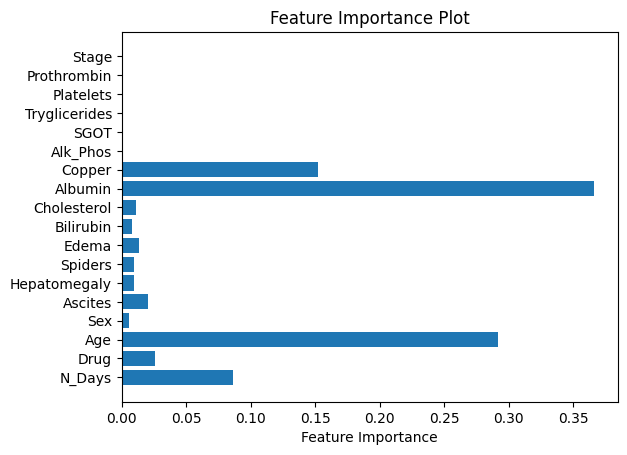

In [ ]:
feature_importances_plot(xgb)

## Notes for improvements

- **Visualize the model evaluation result**

This will help you to understand the details more clearly about your model's performance. From the visualization, you can see clearly if your model is leaning towards a class than the others. (Hint: confusion matrix, ROC-AUC curve, etc.)

- **Explore the hyperparameters of your models**

Each models have their own hyperparameters. And each of the hyperparameter have different effects on the model behaviour. You can optimize the model performance by finding the good set of hyperparameters through a process called **hyperparameter tuning**. (Hint: Grid search, random search, bayesian optimization)

- **Cross-validation**

Cross-validation is a critical technique in machine learning and data science for evaluating and validating the performance of predictive models. It provides a more **robust** and **reliable** evaluation method compared to a hold-out (single train-test set) validation. Though, it requires more time and computing power because of how cross-validation works. (Hint: k-fold cross-validation, stratified k-fold cross-validation, etc.)

- **Ensemble methods**

Ensemble methods are powerful machine learning techniques that combine the predictions of multiple models (often referred to as base learners or weak learners) to create a stronger, more accurate predictive model. The idea behind ensemble methods is that by aggregating the opinions of multiple models, you can reduce the impact of individual model errors and improve overall prediction performance. (Hint: bagging, boosting, stacking, voting)

- **Model interpretation**

Model interpretation is the process of understanding and explaining the inner workings of a machine learning model, particularly its decision-making process. Interpretation helps data scientists, stakeholders, and end-users gain insights into why a model makes certain predictions or classifications. Model interpretation is crucial for building trust in machine learning systems, identifying biases, and extracting actionable information from models. (Hint: Feature importance, PDP, SHAP Values, etc)

- **Explore other models**

There are a lot of ML models that you can use in this usecase. Try to explore and use them to solve this problem.

## Submission
To predict the test set target feature and submit the results to the kaggle competition platform, do the following:
1. Create a new pipeline instance identical to the first in Data Preprocessing
2. With the pipeline, apply `fit_transform` to the original training set before splitting, then only apply `transform` to the test set.
3. Retrain the model on the preprocessed training set
4. Predict the test set
5. Make sure the submission contains the `id`, `Status_C`, `Status_CL`, `Status_D` column.

In [ ]:
X_test_prepared = final_pipeline.transform(df_test)

xgb.fit(X_train_prepared, y_train)

# Predict
y_pred = logisticregression.predict_proba(X_test_prepared)
df_submission = pd.DataFrame(y_pred, columns=['Status_C', 'Status_CL', 'Status_D'])
df_submission['id'] = df_test['id']
df_submission = df_submission[['id', 'Status_C', 'Status_CL', 'Status_D']]
df_submission

target encode


,id,Status_C,Status_CL,Status_D
0,15000,0.151928,0.016379,0.831692
1,15001,0.749697,0.003102,0.247201
2,15002,0.906318,0.002883,0.090799
3,15003,0.910912,0.016452,0.072635
4,15004,0.815655,0.011656,0.172689
...,...,...,...,...
9995,24995,0.928042,0.017812,0.054146
9996,24996,0.486725,0.012370,0.500905
9997,24997,0.075780,0.004662,0.919558
9998,24998,0.016843,0.002047,0.981110


In [ ]:
df_submission.to_csv('submission.csv', index=False)

# 6. Error Analysis

Based on all the process you have done until the modeling and evaluation step, write an analysis to support each steps you have taken to solve this problem. Write the analysis using the markdown block. Some questions that may help you in writing the analysis:

- Does my model perform better in predicting one class than the other? If so, why is that?
- To each models I have tried, which performs the best and what could be the reason?
- Is it better for me to impute or drop the missing data? Why?
- Does feature scaling help improve my model performance?
- etc...

### Impute or Drop Missing Data?

Berdasarkan beberapa percobaan, didapat bahwa impute atau pun drop tidak memberi pengaruh yang signifikan terhadap hasil prediksi. Hal ini terjadi karena fitur-fitur yang penting (berdasarkan hasil feture importance) bukanlah fitur yang memiliki missing data.